In [1]:
import numpy
from h5py import File
from astropy.time import Time
import datetime


import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib.dates as mdates

from processing_data import read_hdf5_file, datetime_to_timestamp, timestamp_to_datetime
from LombScargle_functions import *




In [2]:
def resonance_between_frequencies(T_1, T_2, T_3):
    print(f'T_1: {T_1:.4f}; T_2: {T_2:.4f}, T_3: {T_3:.4f}')
    print('Different combination:')
    T_syno_sin_obs = (T_1*T_2)/numpy.abs(T_1 - T_2)
    T_syno_sin_gap = (T_1*T_3)/numpy.abs(T_1 - T_3)
    T_syno_sin_2gap = (T_1*2*T_3)/numpy.abs(T_1 - 2*T_3)
    T_syno_sin_3gap = (T_1*3*T_3)/numpy.abs(T_1 - 3*T_3)
    T_syno_sin_4gap = (T_1*4*T_3)/numpy.abs(T_1 - 4*T_3)
    print(f'Synodic Period between T_1 and T_2: {T_syno_sin_obs:.3f}')
    print(f'Synodic Period between T_1 and T_3: {T_syno_sin_gap:.3f}')
    print(f'Synodic Period between T_1 and 2xT_gap: {T_syno_sin_2gap:.3f}')
    print(f'Synodic Period between T_1 and 3xT_gap: {T_syno_sin_3gap:.3f}')
    print(f'Synodic Period between T_1 and 4xT_gap: {T_syno_sin_4gap:.3f}')
    
    T_syno_obs_gap = (T_2*T_3)/numpy.abs(T_2 - T_3)
    T_syno_obs_2gap = (T_2*2*T_3)/numpy.abs(T_2 - 2*T_3)
    T_syno_obs_3gap = (T_2*3*T_3)/numpy.abs(T_2 - 3*T_3)
    T_syno_obs_4gap = (T_2*4*T_3)/numpy.abs(T_2 - 4*T_3)
    print(f'Synodic Period between T_2 and T_3: {T_syno_obs_gap:.3f}')
    print(f'Synodic Period between T_2 and 2xT_3: {T_syno_obs_2gap:.3f}')
    print(f'Synodic Period between T_2 and 3xT_3: {T_syno_obs_3gap:.3f}')
    print(f'Synodic Period between T_2 and 4xT_3: {T_syno_obs_4gap:.3f}')

    T_harmonic_sin_obs = 1/(1/T_1 + 1/T_2)
    print(f'Harmonic resonance between T_1 and T_2:')
    print(f'f_sin + f_obs: {T_harmonic_sin_obs:.3f} hours')
    T_harmonic_sin_1gap = 1/(1/T_1+1/T_3)
    T_harmonic_sin_2gap = 1/(1/T_1+2/T_3)
    T_harmonic_sin_3gap = 1/(1/T_1+3/T_3)
    T_harmonic_sin_4gap = 1/(1/T_1+4/T_3)
    print(f'Harmonic resonance between T_1 and T_3:')
    print(f'f_sin + f_gap: {T_harmonic_sin_1gap:.3f} hours')
    print(f'f_sin + 2 x f_gap: {T_harmonic_sin_2gap:.3f} hours')
    print(f'f_sin + 3 x f_gap: {T_harmonic_sin_3gap:.3f} hours')
    print(f'f_sin + 4 x f_gap: {T_harmonic_sin_4gap:.3f} hours')
    T_harmonic_obs_1gap = 1/(1/T_2+1/T_3)
    T_harmonic_obs_2gap = 1/(1/T_2+2/T_3)
    T_harmonic_obs_3gap = 1/(1/T_2+3/T_3)
    T_harmonic_obs_4gap = 1/(1/T_2+4/T_3)
    print(f'Harmonic resonance between T_2 and T_3:')
    print(f'f_obs + f_gap: {T_harmonic_obs_1gap:.3f} hours')
    print(f'f_obs + 2 x f_gap: {T_harmonic_obs_2gap:.3f} hours')
    print(f'f_obs + 3 x f_gap: {T_harmonic_obs_3gap:.3f} hours')
    print(f'f_obs + 4 x f_gap: {T_harmonic_obs_4gap:.3f} hours')


## JUPITER

In [3]:
data_path = './data/processed/KP07/Jupiter/'
filename_VI = 'preliminary_data_Stokes-VI_LT07_Jupiter_masklevel0_50percents_8-90MHz_dt600s_df5MHz_2019_2025_ON.hdf5'


synodic_period_Moons = {
                 'Io':  {'T_value': 42.5, 'T_name': f'Io'},
                 'I/2-IJ_syn': {'T_value': 33.21, 'T_name': r'I/2-IJ$_{syn}$'},
                 'D-IJ_syn': {'T_value': 28.22, 'T_name': r'D-IJ$_{syn}$'},
                 'Day': {'T_value': 23.93, 'T_name': f'day'},
                 'Io/2':{'T_value': 21.229, 'T_name': f'Io/2'},
                 'D-J_syn': {'T_value': 16.95, 'T_name': r'D-J$_{syn}$'},
                 'Io_syn': {'T_value': 12.993, 'T_name': r'Io$_{syn}$'},
                 'Europa_syn': {'T_value': 11.2321, 'T_name': r'Eur$_{syn}$'},
                 'Ganymede_syn': {'T_value': 10.5330, 'T_name': r'Gan$_{syn}$'},
                 'Jupiter': {'T_value': 9.95, 'T_name': 'Jupiter'},
                 'Jup_day_harm': {'T_value': 7.028, 'T_name': r'D-J$_{harm}$'},
                 'Day/2': {'T_value': 11.965, 'T_name': r'$\frac{day}{2}$'},
                 'Jupiter/2':{'T_value':4.975, 'T_name': r'$\frac{J}{2}$'},
                }

cmap = 'Greys'


Reading data from preprocessed hdf5 file (containing V/I stokes ratio) and plot time series of measurements

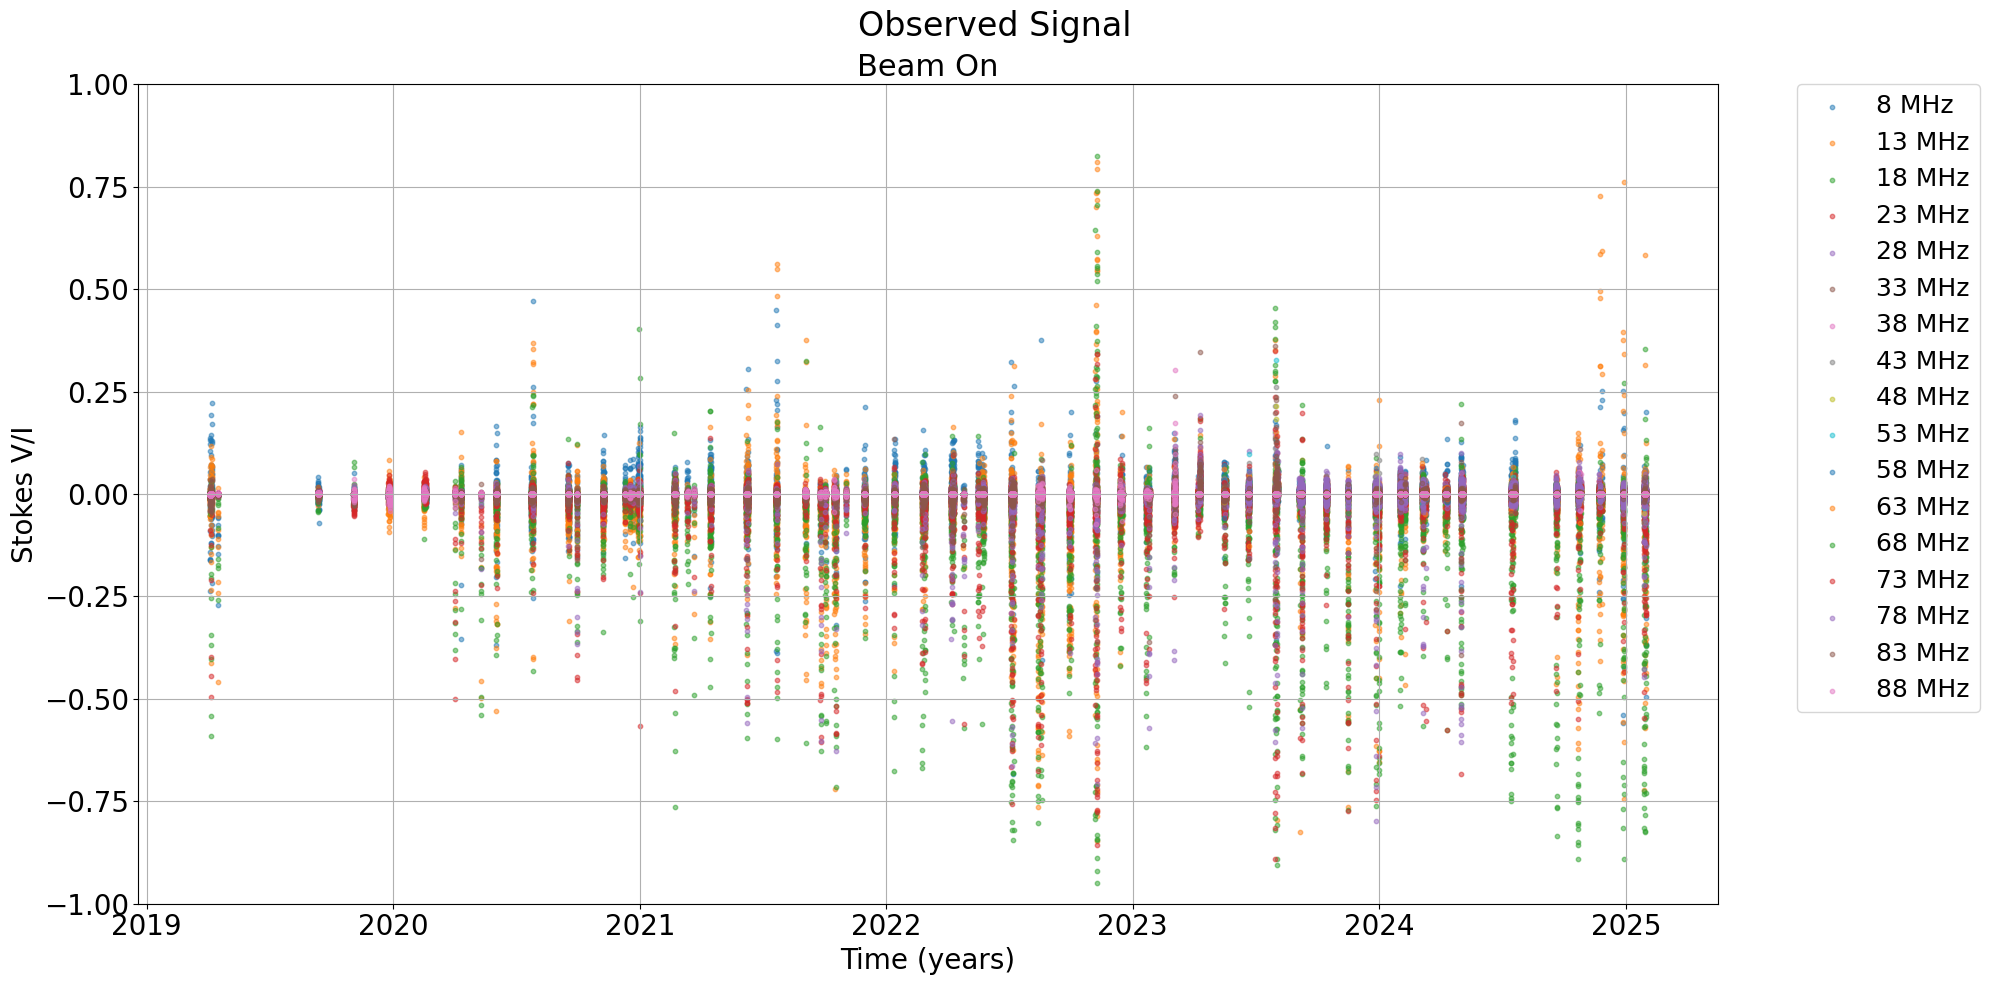

In [4]:
read_and_plot_timeseries(path_to_data = data_path,
                          file_name = filename_VI,
                          target = 'Jupiter',
                          target_type = 'exoplanet', 
                          beam_off_number = 1,
                          extra_title='',
                          beam_on = True,
                          savefig = False,
                          filename = 'timeseries_Jupiter_df5MHz.pdf'
                          )


Reading data from preprocessed hdf5 file (containing V/I stokes ratio), calculate Lomb Scargle Periodogram at all observed frequency channel and plot results (LS periodogram at each observed frequency channel and 2D (LS freq. vs. Observed freq.) LS periodogram)

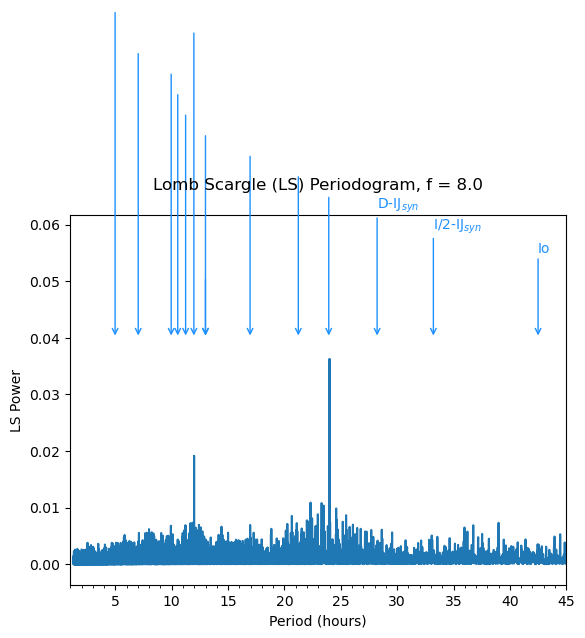

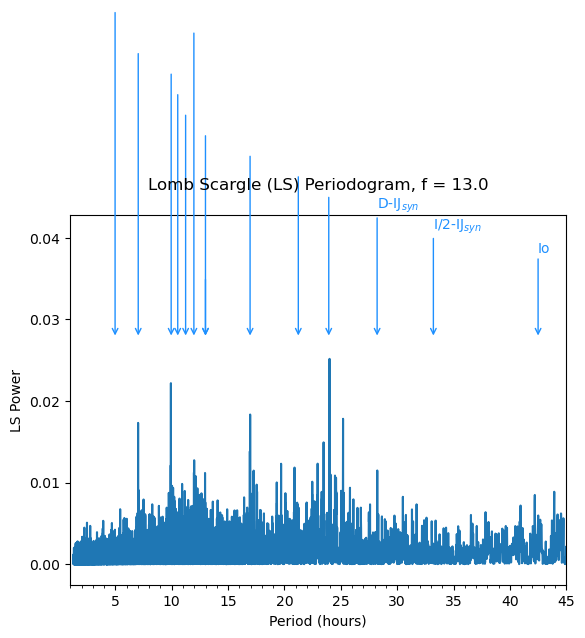

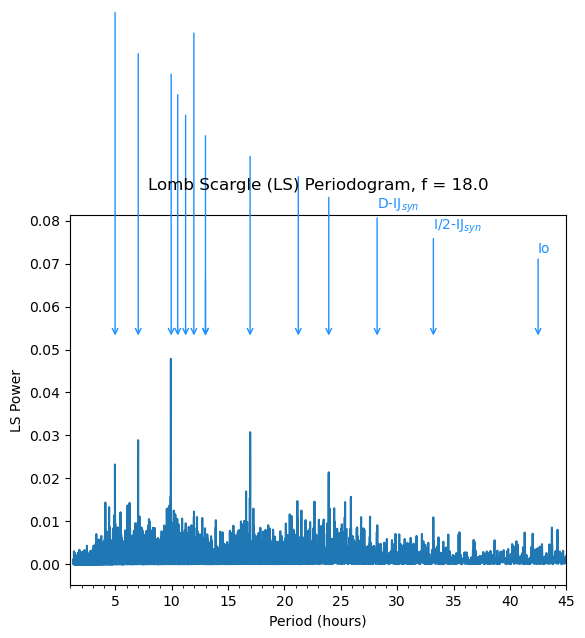

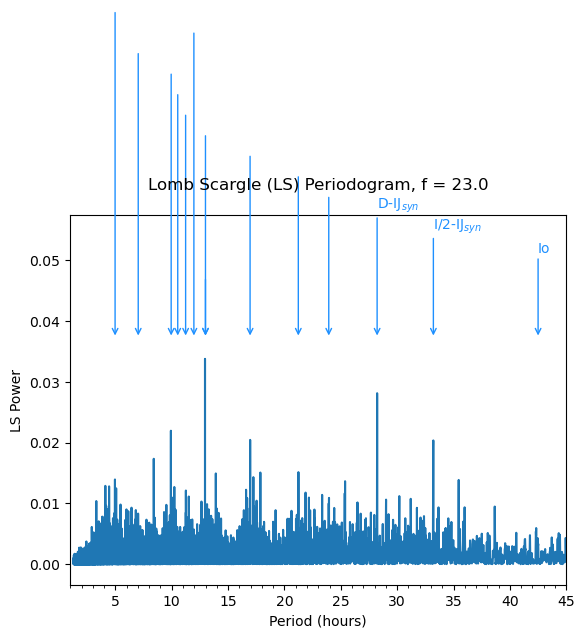

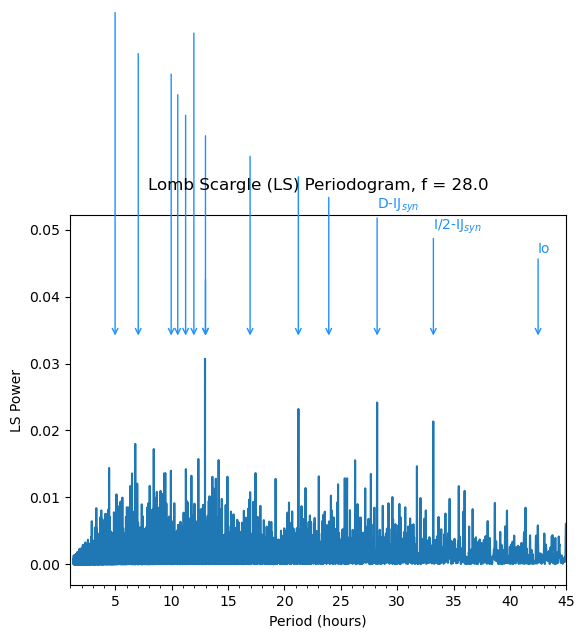

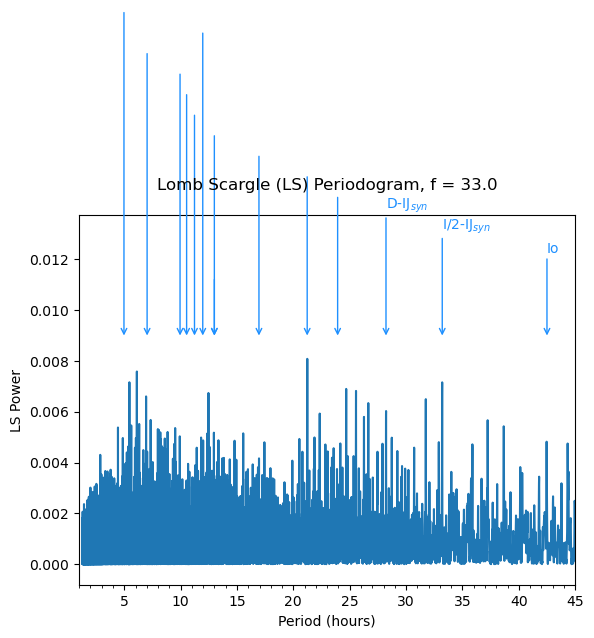

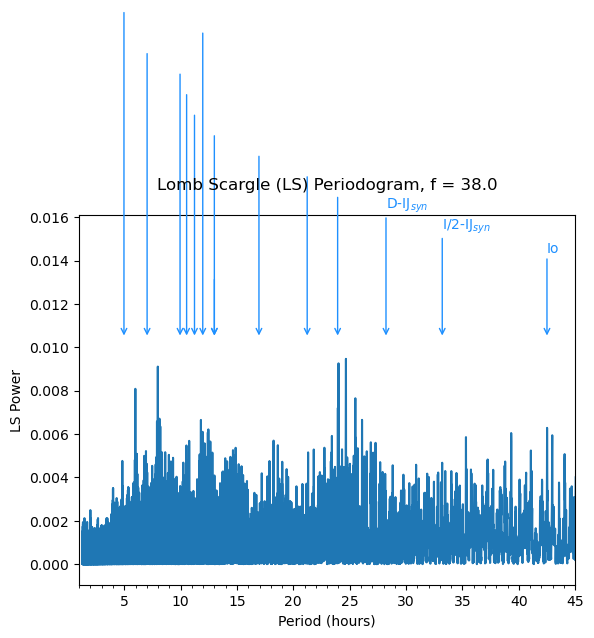

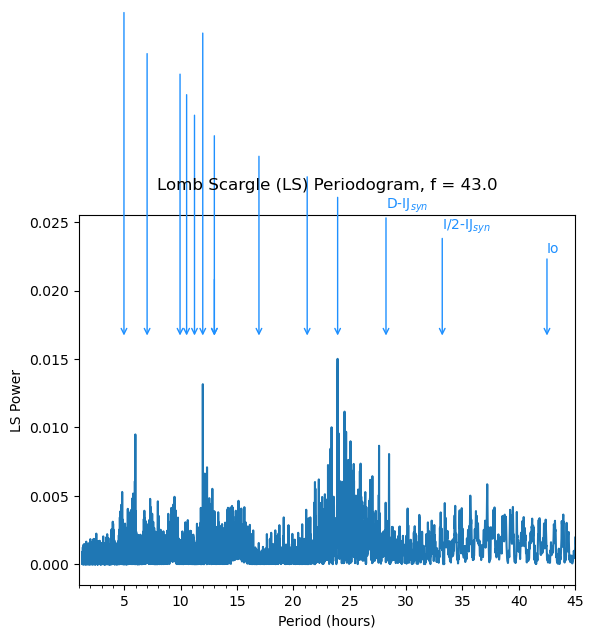

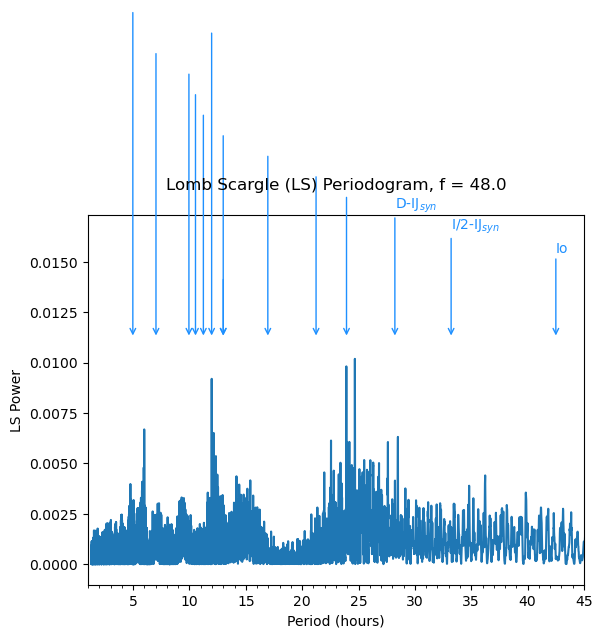

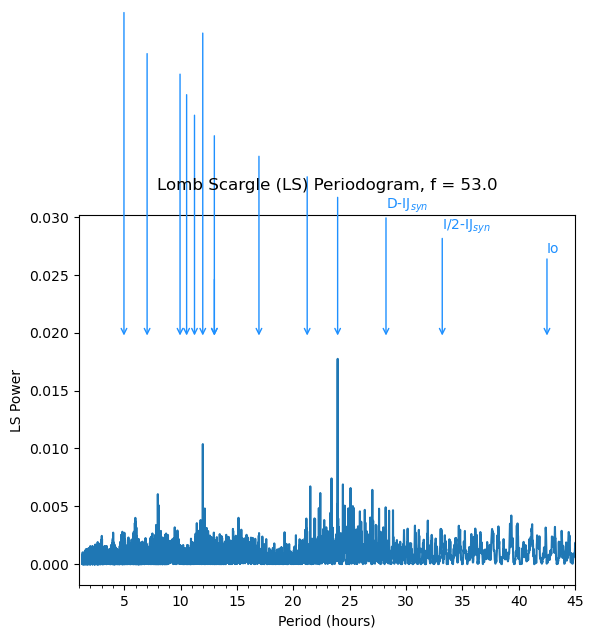

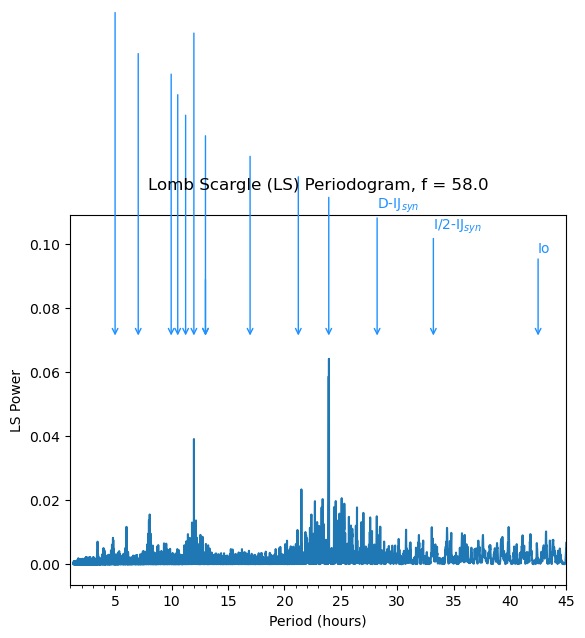

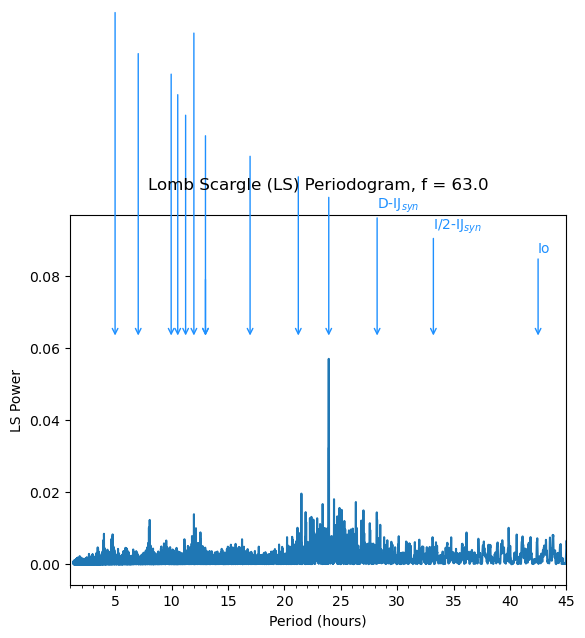

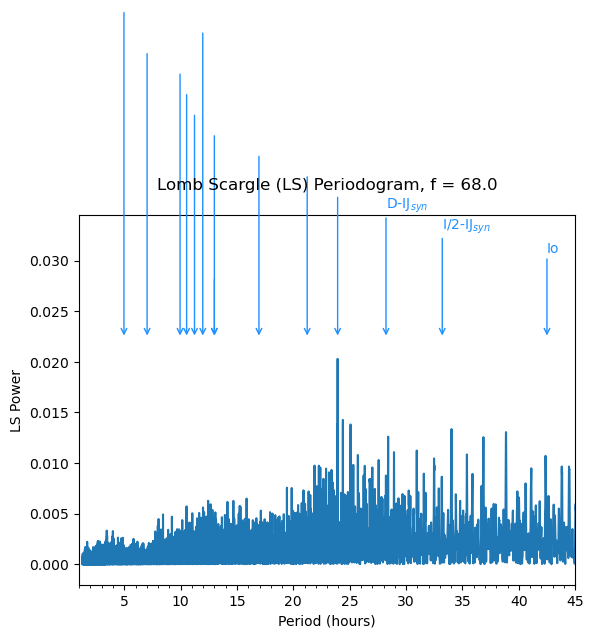

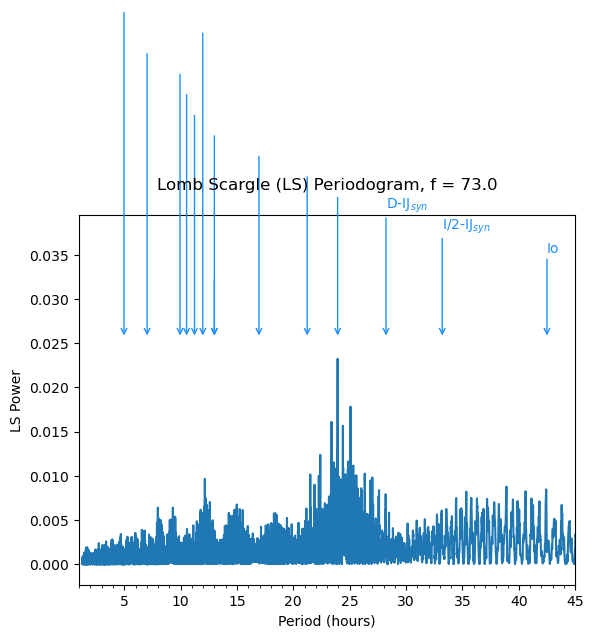

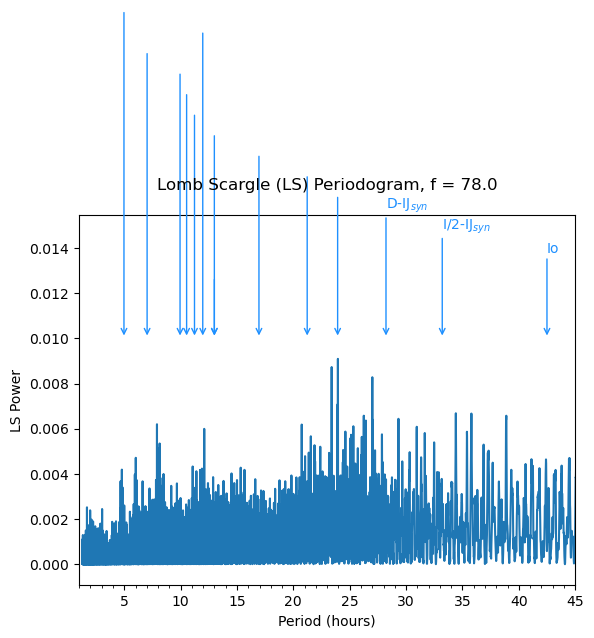

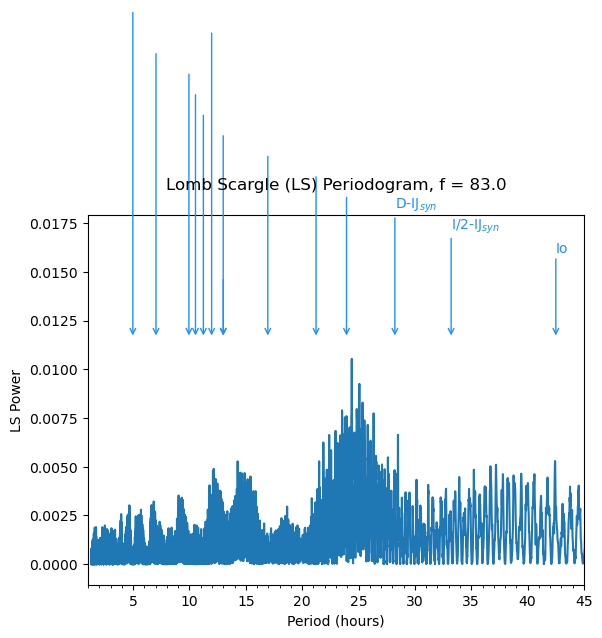

/Users/clouis/anaconda3/envs/python3.8/lib/python3.8/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning: invalid value encountered in divide
  power /= YY


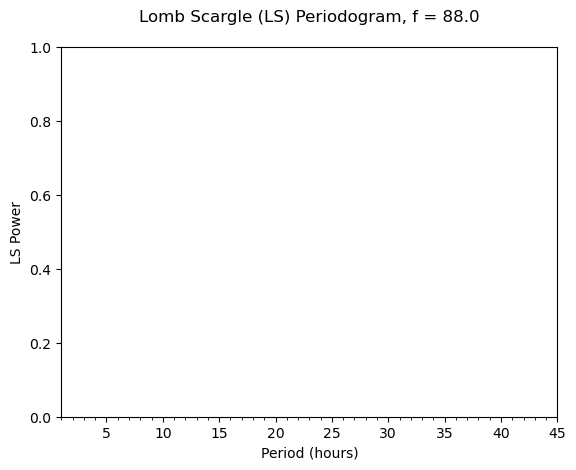

/Users/clouis/anaconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


15 30


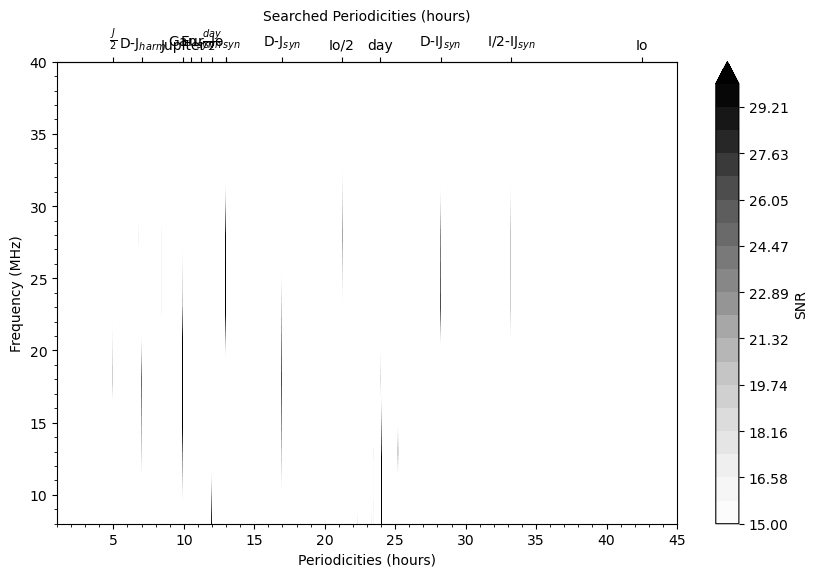

In [5]:
(frequency_LS, frequencies, power_LS_full) = read_data_and_plot_LS(
                          path_to_data = data_path,
                          file_name = filename_VI,
                          target = 'Jupiter', # target name
                          target_type = 'exoplanet', # exoplanet or star
                          T_search = 12.992/24, # Expected periodicity in days (LS will look for periodicity x/ 10 this value)
                          beam_on = True, beam_off = False,
                          beam_off_number = 1, # empty string or number (int or string format)
                          x_zoomin=[1,45],# y_zoomin = [0,0.1],
                          log_x_scale = False,
                          y_T_arrow = None,
                          #T_title = r'Io$_{syn}$',
                          T_title = r'',
                          add_extra_T = synodic_period_Moons,
                          vline = False,
                          color_vline = None,
                          y_zoomin_2D_periodogram = (8,40),
                          vmin = 15, vmax = 30,
                          cmap = cmap,
                          #add_p_values = 'p-test',
                          savefig = False,
                          filename = 'SNR_LS_2D_Jupiter_df5MHz.png'
                          )





Reading data from preprocessed hdf5 file (containing V/I stokes ratio), calculate Lomb Scargle Periodogram *over observing time* in a sliding window, at all observed frequency channel and plot results in  2D (time vs. LS freq) LS periodogram

In [7]:
exoplanet_period_in_hours = 12.993

t_min = datetime.datetime(2019,7,1)

data_path = './data/processed/KP07/Jupiter/'
filename_VI = 'preliminary_data_Stokes-VI_LT07_Jupiter_masklevel0_50percents_8-90MHz_dt600s_df5MHz_2019_2025_ON.hdf5'

(time_datetime_beam_ON,
            frequencies_beam_ON,
            data_final_beam_ON,
            stokes_beam_ON,
            key_project_beam_ON,
            target_beam_ON,
            T_exoplanet_beam_ON,
            T_star_beam_ON
            ) = read_hdf5_file(data_path+filename_VI, dataset=True, LS_dataset = False)


mask_tmin = time_datetime_beam_ON > t_min

data_final_beam_ON = data_final_beam_ON[mask_tmin,:]
time_datetime_beam_ON=time_datetime_beam_ON[mask_tmin]

sorted_indices = numpy.argsort(time_datetime_beam_ON)
data_final_beam_ON = data_final_beam_ON[sorted_indices,:]
time_datetime_beam_ON = time_datetime_beam_ON[sorted_indices]



In [ ]:
for i_window_size in [60*24*10*50]:
        for i_step_size in [24*60*2]:
                filename = f'./outputs/LS_SNR_periodogram_over_time_window{int(i_window_size/60/24)}day_step{int(i_step_size/60/24)}day_no_unphysical_values_8-33MHz_zoomin4-18MHz.png'
                calculate_and_plot_SNR_LS_periodogram_over_time(time_datetime_beam_ON,frequencies_beam_ON, data_final_beam_ON,
                                            cmap = cmap,
                                            exoplanet_period_in_hours = 12.993,
                                            hline_label = '',
                                            x_zoomin = None, # datetime object
                                            LS_y_zoomin = (4,18),
                                            observed_frequency_limits = [8,33],
                                            LS_window_size = i_window_size,  # Number of points in each window (in minutes)
                                            LS_step_size = i_step_size,
                                            vmin = 5, vmax = 15,
                                            add_extra_T = synodic_period_Moons,
                                            savefig = False, filename = filename)



Frequency: 8.0 MHZ
2019-09-11 14:36:55.083886, 2021-01-23 14:36:55.083886
2019-09-13 14:36:55.083886, 2021-01-25 14:36:55.083886
2019-09-15 14:36:55.083886, 2021-01-27 14:36:55.083886
2019-09-17 14:36:55.083886, 2021-01-29 14:36:55.083886
2019-09-19 14:36:55.083886, 2021-01-31 14:36:55.083886
2019-09-21 14:36:55.083886, 2021-02-02 14:36:55.083886
2019-09-23 14:36:55.083886, 2021-02-04 14:36:55.083886
2019-09-25 14:36:55.083886, 2021-02-06 14:36:55.083886
2019-09-27 14:36:55.083886, 2021-02-08 14:36:55.083886
2019-09-29 14:36:55.083886, 2021-02-10 14:36:55.083886
2019-10-01 14:36:55.083886, 2021-02-12 14:36:55.083886
2019-10-03 14:36:55.083886, 2021-02-14 14:36:55.083886
2019-10-05 14:36:55.083886, 2021-02-16 14:36:55.083886
2019-10-07 14:36:55.083886, 2021-02-18 14:36:55.083886
2019-10-09 14:36:55.083886, 2021-02-20 14:36:55.083886
2019-10-11 14:36:55.083886, 2021-02-22 14:36:55.083886
2019-10-13 14:36:55.083886, 2021-02-24 14:36:55.083886
2019-10-15 14:36:55.083886, 2021-02-26 14:36:5

Same as before, but with elevation of Jupiter in the sky (more file necessary)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import matplotlib.dates as mdates

jup_elevation_path = "./data/Jupiter_elevation/"
jd = np.load(f"{jup_elevation_path}2019_2025_jup_jd.npy")
fraction = np.load(f"{jup_elevation_path}2019_2025_jup_fraction.npy")


period_day = {
                 'Day': {'T_value': 23.93, 'T_name': f'day'},
                 'Day/2': {'T_value': 11.965, 'T_name': r'$\frac{day}{2}$'},
                }

#for i_window_size in [100, 500, 1000, 2000, 3000, 4000]:
#    for i_step_size in [10, 50, 100, 200, 400, 600]:
#for i_window_size in [60*24*10*10, 60*24*10*20 ,60*24*10*30, 60*24*10*40, 60*24*10*50]:
#        for i_step_size in [24*60, 24*60*2, 24*60*4, 24*60*7, 24*60*15]:
for i_window_size in [60*24*10*30]:
        for i_step_size in [24*60*2]:
                filename = f'./outputs/LS_periodogram_over_time_window{int(i_window_size/60/24)}day_step{int(i_step_size/60/24)}_withephem.png'
                #if i_step_size <= i_window_size:
                calculate_and_plot_SNR_LS_periodogram_over_time(time_datetime_beam_ON,frequencies_beam_ON, data_final_beam_ON,
                                            cmap = 'Greys',
                                            exoplanet_period_in_hours = 12.993,
                                            hline_label = '',
                                            x_zoomin = None, # datetime object
                                            LS_y_zoomin = (4,45),
                                            observed_frequency_limits = [8,8],
                                            LS_window_size = i_window_size,  # Number of points in each window (in minutes)
                                            LS_step_size = i_step_size,
                                            vmin = 5, vmax = 15,
                                            add_extra_T = period_day,
                                            savefig = False, filename = filename,
                                            extra_panel_data = [Time(jd, format="jd").datetime, fraction*100],
                                            extra_panel_ytitle = 'Jupiter visibility in the night sky\n(%)')



Frequency: 8.0 MHZ
2019-09-11 14:36:55.083886, 2020-07-07 14:36:55.083886
2019-09-13 14:36:55.083886, 2020-07-09 14:36:55.083886
2019-09-15 14:36:55.083886, 2020-07-11 14:36:55.083886
2019-09-17 14:36:55.083886, 2020-07-13 14:36:55.083886
2019-09-19 14:36:55.083886, 2020-07-15 14:36:55.083886
2019-09-21 14:36:55.083886, 2020-07-17 14:36:55.083886
2019-09-23 14:36:55.083886, 2020-07-19 14:36:55.083886
2019-09-25 14:36:55.083886, 2020-07-21 14:36:55.083886
2019-09-27 14:36:55.083886, 2020-07-23 14:36:55.083886
2019-09-29 14:36:55.083886, 2020-07-25 14:36:55.083886
2019-10-01 14:36:55.083886, 2020-07-27 14:36:55.083886
2019-10-03 14:36:55.083886, 2020-07-29 14:36:55.083886
2019-10-05 14:36:55.083886, 2020-07-31 14:36:55.083886
2019-10-07 14:36:55.083886, 2020-08-02 14:36:55.083886
2019-10-09 14:36:55.083886, 2020-08-04 14:36:55.083886
2019-10-11 14:36:55.083886, 2020-08-06 14:36:55.083886
2019-10-13 14:36:55.083886, 2020-08-08 14:36:55.083886
2019-10-15 14:36:55.083886, 2020-08-10 14:36:5